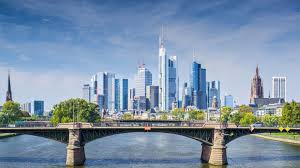

In [3]:
from IPython.display import Image
Image(filename='ffm.png')

# Frankfurt visitors venue recommendation

## Segmenting and Clustering Neighborhoods in Frankfurt am Main

### **Introduction**

In this project, I will convert addresses into their equivalent latitude and longitude values. Also, I will use the Foursquare API to explore neighborhoods in Frankfurt City. I will use the "explore" function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. I will also use the *k*-means clustering algorithm to complete this task.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [114]:
# Before get the data and start exploring it, let's download all the dependencies that are required

import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


<a id='item1'></a>

## 1. Load and Explore Dataset

In [2]:
# I generated manually a table with Frankfrut Postalcode, Borogh and Neighborhoods information, 
# because there is so no well organized table in internet

# let's read csv file and start explore the dataset

In [53]:
Ffm_data = "ffm.csv" # get data in csv form
FFm_df = pd.read_csv(Ffm_data).set_index("Postal code")

FFm_df.head(15)

,Borough,Neighbourhood,Latitude,Longitude
Postal code,,,,
60306,Innenstadt II,Westend-Süd,50.115245,8.662270
60308,Innenstadt II,Westend-Süd,50.111432,8.647591
60310,Innenstadt I,Innenstadt,50.111432,8.647591
60311,Innenstadt I,Altstadt,50.110644,8.682092
60311,Innenstadt I,Innenstadt,50.111432,8.647591
60314,Ost,Fechenheim,50.111432,8.647591
60314,Bornheim/Ostend,Ostend,50.133056,8.714932
60316,Innenstadt III,Nordend-Ost,50.124920,8.692317
60316,Innenstadt III,Nordend-West,50.124914,8.677950


#### Create a map of Frankfurt

In [54]:
geo = Nominatim(user_agent='My-IBMNotebook')
address = 'Frankfurt am Main'
location = geo.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Frankfurt {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Frankfurt 50.1106444, 8.6820917.


#### The geograpical coordinate of Frankfurt from geo match Borough coordinate table. 

#### Let's create a map of Frankfurt with neighborhoods superimposed on top.

In [55]:
# create map of Frankurt using latitude and longitude values
map_Frankfurt = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(FFm_df['Latitude'], FFm_df['Longitude'], FFm_df['Borough'], FFm_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Frankfurt)  
    
map_Frankfurt

However, let's simplify the issue and segment and cluster only the neighborhoods in Innenstadt II, because of nearness to our firm Headquarter. It is not as expensive (Hotel price per night) as Innenstadt I.

In [94]:
Working_data = FFm_df[FFm_df['Borough'] == 'Innenstadt II'].reset_index(drop=True)
Working_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Innenstadt II,Westend-Süd,50.115245,8.662270
1,Innenstadt II,Westend-Süd,50.111432,8.647591
2,Innenstadt II,Westend-Nord,50.111432,8.647591
3,Innenstadt II,Westend-Süd,50.115245,8.662270
4,Innenstadt II,Bockenheim,50.122361,8.637532


Next, I am going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [58]:
CLIENT_ID = 'GHUHQQO1VVFBAAMS5JEQD1FSRUVIBYDRZIMWCMHA3QI5YXRZ' # your Foursquare ID
CLIENT_SECRET = 'CAALT0DFHNJPUB1GSI4JRL1S005OCT3U44BU255VSTBBNHJ2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [59]:
Working_data.loc[0, 'Neighbourhood']

'Westend-Süd'

Get the neighborhood's latitude and longitude values.

In [61]:
neighborhood_latitude = Working_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Working_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Working_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

LIMIT = 150
radius = 1000
link = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)


Latitude and longitude values of Westend-Süd are 50.115245, 8.66227.


#### Send the GET request and examine the resutls

In [62]:
results = requests.get(link).json()
results

{'meta': {'code': 200, 'requestId': '5c7bc94b6a60714c801abc53'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Westend-Süd',
  'headerFullLocation': 'Westend-Süd, Frankfurt am Main',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 235,
  'suggestedBounds': {'ne': {'lat': 50.12424500900001,
    'lng': 8.676278995248635},
   'sw': {'lat': 50.10624499099999, 'lng': 8.648261004751364}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b6025d0f964a52069d729e3',
       'name': 'M-Steakhouse',
       'location': {'address': 'Feuerbachstr. 11a',
        'lat': 50.11478186640996,
        'lng': 8.662610545276616,
        'labeledLatLngs': [{'label': 'display',
          '

Before I'll proceed, I borrow the **get_category_type** function from the Foursquare lab.

In [63]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now I clean the json and structure it into a *pandas* dataframe.

In [64]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,M-Steakhouse,Steakhouse,50.114782,8.662611
1,Westendplatz,Plaza,50.112916,8.661763
2,Das Nudel Ding,Chinese Restaurant,50.115797,8.663362
3,La Scuderia,Italian Restaurant,50.115464,8.662881
4,Ramen Jun,Ramen Restaurant,50.113201,8.655861
5,Saverio's Florian,Italian Restaurant,50.115767,8.664076
6,l'unico,Italian Restaurant,50.118159,8.659280
7,Moriki,Japanese Restaurant,50.113863,8.669530
8,The Ivory Club,Indian Restaurant,50.114309,8.669109
9,Prime Time Fitness,Gym,50.117589,8.666662


Quantity of venues were returned by Foursquare

In [65]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


<a id='item2'></a>

## 2. Explore Neighborhoods in Innenstadt II

#### Let's create a function to repeat the same process to all the neighborhoods in Innenstadt II

In [106]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get nearby venues

In [107]:

Frankfurt_venues = getNearbyVenues(names=Working_data['Neighbourhood'],
                                   latitudes=Working_data['Latitude'],
                                   longitudes=Working_data['Longitude']
                                  )



Westend-Süd
Westend-Süd
Westend-Nord
Westend-Süd
Bockenheim


#### Let's check the size of the resulting dataframe

In [108]:
print(Frankfurt_venues.shape)
Frankfurt_venues.head(15)

(500, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Westend-Süd,50.115245,8.66227,M-Steakhouse,50.114782,8.662611,Steakhouse
1,Westend-Süd,50.115245,8.66227,Westendplatz,50.112916,8.661763,Plaza
2,Westend-Süd,50.115245,8.66227,Das Nudel Ding,50.115797,8.663362,Chinese Restaurant
3,Westend-Süd,50.115245,8.66227,La Scuderia,50.115464,8.662881,Italian Restaurant
4,Westend-Süd,50.115245,8.66227,Ramen Jun,50.113201,8.655861,Ramen Restaurant
5,Westend-Süd,50.115245,8.66227,Saverio's Florian,50.115767,8.664076,Italian Restaurant
6,Westend-Süd,50.115245,8.66227,l'unico,50.118159,8.659280,Italian Restaurant
7,Westend-Süd,50.115245,8.66227,Moriki,50.113863,8.669530,Japanese Restaurant
8,Westend-Süd,50.115245,8.66227,The Ivory Club,50.114309,8.669109,Indian Restaurant
9,Westend-Süd,50.115245,8.66227,Prime Time Fitness,50.117589,8.666662,Gym


Let's check how many venues were returned for each neighborhood

In [70]:
Frankfurt_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bockenheim,24,24,24,24,24,24
Westend-Nord,41,41,41,41,41,41
Westend-Süd,89,89,89,89,89,89


#### Let's find out how many unique categories can be curated from all the returned venues

In [71]:
print('There are {} uniques categories.'.format(len(Frankfurt_venues['Venue Category'].unique())))

There are 43 uniques categories.


<a id='item3'></a>

## 3. Analyze Neighborhoods

In [72]:
# one hot encoding
Frankfurt_onehot = pd.get_dummies(Frankfurt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Frankfurt_onehot['Neighborhood'] = Frankfurt_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Frankfurt_onehot.columns[-1]] + list(Frankfurt_onehot.columns[:-1])
Frankfurt_onehot = Frankfurt_onehot[fixed_columns]

Frankfurt_onehot.head()

,Neighborhood,Asian Restaurant,Bakery,Bar,Beer Store,Bus Stop,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Currywurst Joint,Department Store,Drugstore,French Restaurant,Greek Restaurant,Gym,Hookah Bar,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Park,Platform,Playground,Plaza,Pub,Radio Station,Ramen Restaurant,Shopping Mall,Snack Place,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Turkish Restaurant,Wine Bar
0,Westend-Süd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Westend-Süd,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Westend-Süd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,Westend-Süd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Westend-Süd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [73]:
Frankfurt_onehot.shape

(154, 44)

#### Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [74]:
Frankfurt_grouped = Frankfurt_onehot.groupby('Neighborhood').mean().reset_index()
Frankfurt_grouped

,Neighborhood,Asian Restaurant,Bakery,Bar,Beer Store,Bus Stop,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Currywurst Joint,Department Store,Drugstore,French Restaurant,Greek Restaurant,Gym,Hookah Bar,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Park,Platform,Playground,Plaza,Pub,Radio Station,Ramen Restaurant,Shopping Mall,Snack Place,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Turkish Restaurant,Wine Bar
0,Bockenheim,0.083333,0.000000,0.041667,0.000000,0.041667,0.125000,0.000000,0.041667,0.000000,0.000000,0.041667,0.000000,0.041667,0.000000,0.000000,0.041667,0.041667,0.041667,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.041667,0.041667,0.041667,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.00000,0.041667,0.000000,0.041667,0.041667,0.041667
1,Westend-Nord,0.024390,0.024390,0.000000,0.024390,0.000000,0.048780,0.000000,0.000000,0.048780,0.024390,0.000000,0.024390,0.000000,0.024390,0.024390,0.000000,0.024390,0.000000,0.268293,0.024390,0.000000,0.024390,0.048780,0.024390,0.048780,0.000000,0.024390,0.048780,0.000000,0.000000,0.000000,0.024390,0.000000,0.000000,0.024390,0.024390,0.024390,0.04878,0.024390,0.024390,0.000000,0.000000,0.000000
2,Westend-Süd,0.011236,0.033708,0.022472,0.011236,0.000000,0.044944,0.022472,0.000000,0.022472,0.011236,0.022472,0.011236,0.000000,0.011236,0.033708,0.000000,0.033708,0.000000,0.123596,0.011236,0.022472,0.191011,0.044944,0.011236,0.022472,0.000000,0.011236,0.022472,0.000000,0.000000,0.022472,0.011236,0.000000,0.022472,0.011236,0.011236,0.011236,0.11236,0.033708,0.011236,0.000000,0.000000,0.000000


#### Let's confirm the new size

In [75]:
Frankfurt_grouped.shape

(3, 44)

#### Let's print each neighborhood along with the top 5 most common venues

In [76]:
num_top_venues = 5

for hood in Frankfurt_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Frankfurt_grouped[Frankfurt_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bockenheim----
                venue  freq
0                Café  0.12
1    Asian Restaurant  0.08
2      Ice Cream Shop  0.08
3    Greek Restaurant  0.04
4  Turkish Restaurant  0.04


----Westend-Nord----
                 venue  freq
0                Hotel  0.27
1                 Park  0.05
2  Japanese Restaurant  0.05
3           Steakhouse  0.05
4                 Café  0.05


----Westend-Süd----
                 venue  freq
0   Italian Restaurant  0.19
1                Hotel  0.12
2           Steakhouse  0.11
3  Japanese Restaurant  0.04
4                 Café  0.04




#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [77]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [111]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Frankfurt_grouped['Neighborhood']

for ind in np.arange(Frankfurt_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Frankfurt_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bockenheim,Café,Asian Restaurant,Ice Cream Shop,Platform,Bar,Bus Stop,Cocktail Bar,Convenience Store,Department Store,Greek Restaurant
1,Westend-Nord,Hotel,Park,Japanese Restaurant,Café,Steakhouse,Coffee Shop,Mexican Restaurant,Italian Restaurant,Gym,Ice Cream Shop
2,Westend-Süd,Italian Restaurant,Hotel,Steakhouse,Japanese Restaurant,Café,Bakery,Supermarket,Gym,French Restaurant,Convenience Store


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 3 clusters.

In [80]:
# set number of clusters
kclusters = 3

Frankfurt_grouped_clustering = Frankfurt_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Frankfurt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [81]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Frankfurt_merged = Working_data

# merge frankfurt_grouped with frankfurt_data to add latitude/longitude for each neighborhood
Frankfurt_merged = Frankfurt_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

Frankfurt_merged.head() 

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Innenstadt II,Westend-Süd,50.115245,8.662270,1,Italian Restaurant,Hotel,Steakhouse,Japanese Restaurant,Café,Bakery,Supermarket,Gym,French Restaurant,Convenience Store
1,Innenstadt II,Westend-Süd,50.111432,8.647591,1,Italian Restaurant,Hotel,Steakhouse,Japanese Restaurant,Café,Bakery,Supermarket,Gym,French Restaurant,Convenience Store
2,Innenstadt II,Westend-Nord,50.111432,8.647591,2,Hotel,Park,Japanese Restaurant,Café,Steakhouse,Coffee Shop,Mexican Restaurant,Italian Restaurant,Gym,Ice Cream Shop
3,Innenstadt II,Westend-Süd,50.115245,8.662270,1,Italian Restaurant,Hotel,Steakhouse,Japanese Restaurant,Café,Bakery,Supermarket,Gym,French Restaurant,Convenience Store
4,Innenstadt II,Bockenheim,50.122361,8.637532,0,Café,Asian Restaurant,Ice Cream Shop,Platform,Bar,Bus Stop,Cocktail Bar,Convenience Store,Department Store,Greek Restaurant


Finally, let's visualize the resulting clusters

In [82]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Frankfurt_merged['Latitude'], Frankfurt_merged['Longitude'], Frankfurt_merged['Neighbourhood'], Frankfurt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

I examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

#### Cluster 1

In [84]:
Frankfurt_merged.loc[Frankfurt_merged['Cluster Labels'] == 0, Frankfurt_merged.columns[[1] + list(range(5, Frankfurt_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bockenheim,Café,Asian Restaurant,Ice Cream Shop,Platform,Bar,Bus Stop,Cocktail Bar,Convenience Store,Department Store,Greek Restaurant


#### Cluster 2

In [85]:
Frankfurt_merged.loc[Frankfurt_merged['Cluster Labels'] == 1, Frankfurt_merged.columns[[1] + list(range(5, Frankfurt_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Westend-Süd,Italian Restaurant,Hotel,Steakhouse,Japanese Restaurant,Café,Bakery,Supermarket,Gym,French Restaurant,Convenience Store
1,Westend-Süd,Italian Restaurant,Hotel,Steakhouse,Japanese Restaurant,Café,Bakery,Supermarket,Gym,French Restaurant,Convenience Store
3,Westend-Süd,Italian Restaurant,Hotel,Steakhouse,Japanese Restaurant,Café,Bakery,Supermarket,Gym,French Restaurant,Convenience Store


#### Cluster 3

In [86]:
Frankfurt_merged.loc[Frankfurt_merged['Cluster Labels'] == 2, Frankfurt_merged.columns[[1] + list(range(5, Frankfurt_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Westend-Nord,Hotel,Park,Japanese Restaurant,Café,Steakhouse,Coffee Shop,Mexican Restaurant,Italian Restaurant,Gym,Ice Cream Shop
